# **Prevendo Customer Churn em Operadoras de Telecom**
Customer Churn (ou Rotatividade de Clientes, em uma tradução livre)
refere-se a uma decisão tomada pelo cliente sobre o término do relacionamento
comercial. Refere-se também à perda de clientes. A fidelidade do cliente e a
rotatividade de clientes sempre somam 100%. Se uma empresa tem uma taxa de
fidelidade de 60%, então a taxa de perda de clientes é de 40%. De acordo com a
regra de lucratividade do cliente 80/20, 20% dos clientes estão gerando 80% da
receita. Portanto, é muito importante prever os usuários que provavelmente
abandonarão o relacionamento comercial e os fatores que afetam as decisões do
cliente. <br>
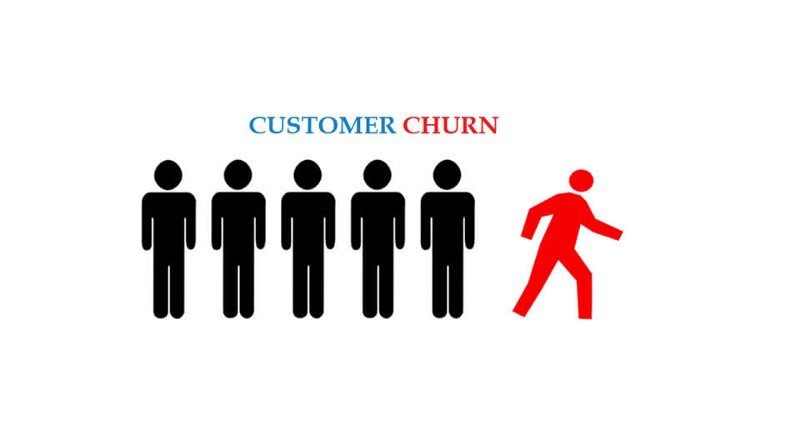

# 1 - Importando pacotes necessários para o projeto

In [ ]:
# Carregando pacotes necessários
from google.colab import drive
drive.mount('/gdrive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, f1_score, recall_score, roc_auc_score
import plotly.express as px
import plotly.graph_objects as go
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.externals import joblib
from imblearn.over_sampling import SMOTE
import pickle
import warnings
warnings.filterwarnings('ignore')

Mounted at /gdrive


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from s

# 2 - Carregando a base de dados

In [ ]:
# Carregando base de dados
df_train = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Churn_Telecom/projeto4_telecom_treino.csv')

In [ ]:
# Visualizando as 5 primeiras linhas
df_train.head()

,Unnamed: 0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,4,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,5,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


# 3 - Análise Exploratória

## Q1. Quais são os nomes das colunas e seus tipos?

In [ ]:
# Colunas existentes na base de dados
df_train.columns

Index(['Unnamed: 0', 'state', 'account_length', 'area_code',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls', 'churn'],
      dtype='object')

In [ ]:
# Tipo das variáveis
df_train.dtypes

Unnamed: 0                         int64
state                             object
account_length                     int64
area_code                         object
international_plan                object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churn                             object
dtype: object

## Q2. Os dados são balanceados?

In [ ]:
# Quantidade de ocorrências para cada classe
df_train.churn.value_counts()

no     2850
yes     483
Name: churn, dtype: int64

In [ ]:
# Percentual de ocorrências da variável target "churn == yes"
df_train.churn.value_counts().values[1] / df_train.churn.value_counts().values.sum()

0.14491449144914492

Os dados não estão balanceados, há 14% de registros para classe "churn == yes", ou seja, ele irá responder muito bem para a classe marjoritária "churn == no", mas terá um desempenho inferior para a classe minoritária. Para resolver esse problema, será necessário o uso da ténica de over-sampling balancear os dados que será implementado na preparação dos dados.

## Q3. Há valores missings no conjunto de dados?

In [ ]:
# Somando os valores missing por coluna
df_train.isnull().sum()

Unnamed: 0                       0
state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64

Não há valores missing.

## Q4. Qual o volume de Clientes por Estado?

In [ ]:
states_churn = df_train.groupby(['state', 'churn'])['Unnamed: 0'].count().reset_index()
dic = {}; dic['state'] = []; dic['churn_no'] = []; dic['churn_yes'] = [];
for i in range(len(states_churn['churn'])):
  if states_churn.iloc[i].values[0] in dic['state']:
    pass
  else:
    dic['state'].append(states_churn.iloc[i].values[0])
  if states_churn.iloc[i].values[1] == 'yes': 
    dic['churn_yes'].append(states_churn.iloc[i].values[2])
  else:
    dic['churn_no'].append(states_churn.iloc[i].values[2])
states_churn = pd.DataFrame.from_dict(dic)
states_churn['total'] = states_churn['churn_no'] + states_churn['churn_yes']
states_fullName = ['Alasca', 'Alabama', 'Arcansas', 'Arizona', 'Califórnia', 'Colorado', 'Coneticute', 'Washington DC', 'Delaware', 'Flórida', 'Geórgia', 'Havaí', 'Iowa', 'Idaho', 'Ilinóis', 'Indiana', 'Cansas', 'Kentucky',
 'Luisiana', 'Massachusetts', 'Marilândia', 'Maine', 'Míchigan', 'Minesota', 'Missúri', 'Mississípi', 'Montana', 'Carolina do Norte', 'Dakota do Norte', 'Nebrasca', 'Nova Hampshire', 'Nova Jérsei', 
 'Novo México', 'Nevada', 'Nova Iorque', 'Ohio', 'Oclaoma', 'Óregon', 'Pensilvânia', 'Ilha de Rodes', 'Carolina do Sul', 'Dakota do Sul', 'Tenessi', 'Texas', 'Utá', 'Virgínia', 'Vermonte', 'Washington', 
 'Wisconsin', 'Virgínia Ocidental', 'Wyoming']
states_churn['state_fullName'] = states_fullName
states_churn['percent_churn'] = states_churn['churn_yes'] / states_churn['total']
states_churn = states_churn[['state', 'state_fullName', 'churn_no', 'churn_yes', 'percent_churn', 'total']].sort_values(by = 'total', ascending = False)

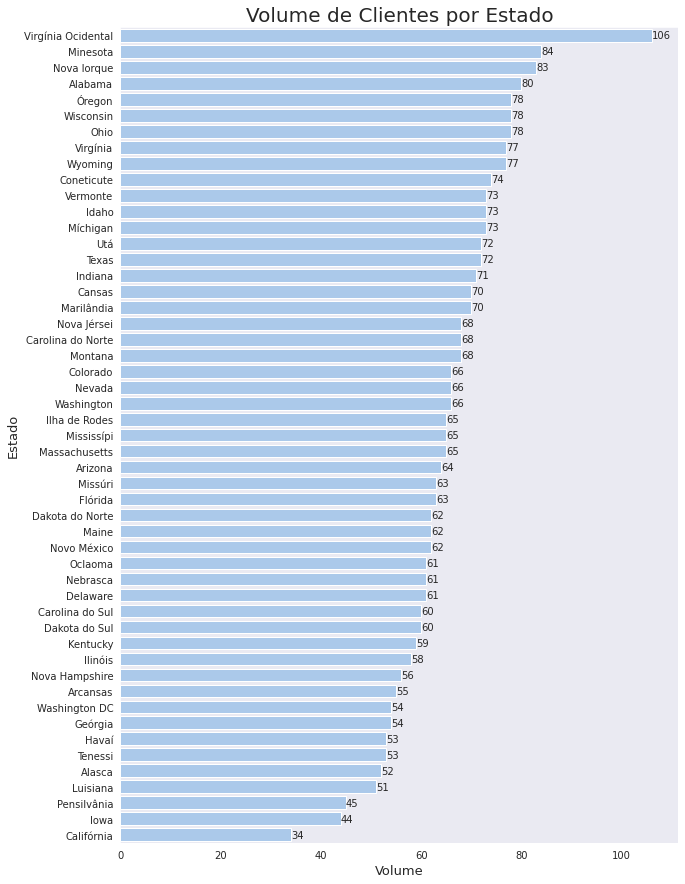

In [ ]:
f, ax = plt.subplots(figsize=(10, 15))
plt.title('Volume de Clientes por Estado', fontdict= {'fontsize': 20})
sns.set_color_codes('pastel')
sns.set_style('dark')
g = sns.barplot(x = 'total', y = 'state_fullName', data = states_churn, orient = 'h', color="b", label = 'Total')
for index, row  in zip(range(len(states_churn.state_fullName)), states_churn.total):
  g.text(row + 0.0019, index + 0.2, round(row, 2))
plt.xlabel('Volume', fontsize = 13)
plt.ylabel('Estado', fontsize = 13)
plt.show()

In [ ]:
px.scatter_geo(states_churn, locations = 'state', locationmode = 'USA-states',
               size = 'total', hover_name= 'state_fullName', scope = 'usa', text = 'churn_yes', 
               color_discrete_sequence=px.colors.qualitative.D3)

## Q5. Qual o volume de Churn por Estado em termos de Perncetual?

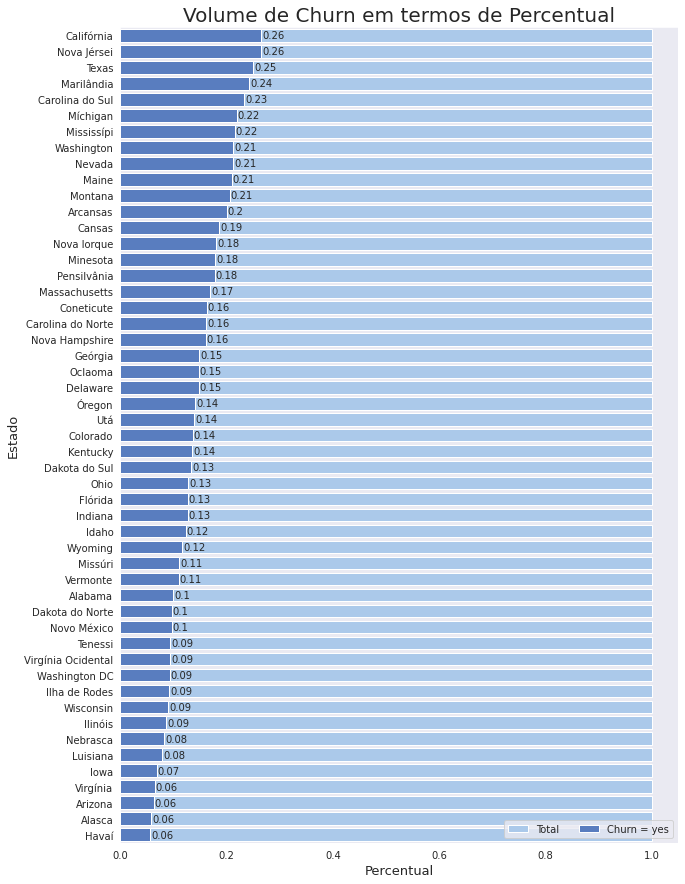

In [ ]:
states_churn = states_churn.sort_values(by='percent_churn', ascending=False)
f, ax = plt.subplots(figsize=(10, 15))
plt.title('Volume de Churn em termos de Percentual', fontdict= {'fontsize': 20})
sns.set_color_codes('pastel')
states_churn['percent'] = 1
sns.barplot(x = 'percent', y = 'state_fullName', data = states_churn, orient = 'h', color="b", label = 'Total')
sns.set_color_codes('muted')
g = sns.barplot(x = 'percent_churn', y = 'state_fullName', data = states_churn, orient = 'h', color="b", label = 'Churn = yes')
for index, row  in zip(range(len(states_churn.state_fullName)), states_churn.percent_churn):
  g.text(row + 0.0019, index + 0.2, round(row, 2))
plt.xlabel('Percentual', fontsize = 13)
plt.ylabel('Estado', fontsize = 13)
ax.legend(ncol = 2, loc = 'lower right', frameon = True)
plt.show()

In [ ]:
df_train['area_code'].value_counts()

area_code_415    1655
area_code_510     840
area_code_408     838
Name: area_code, dtype: int64

## Q6. Qual a distribuição da Variável account_length para churn = 0 e churn = 1?

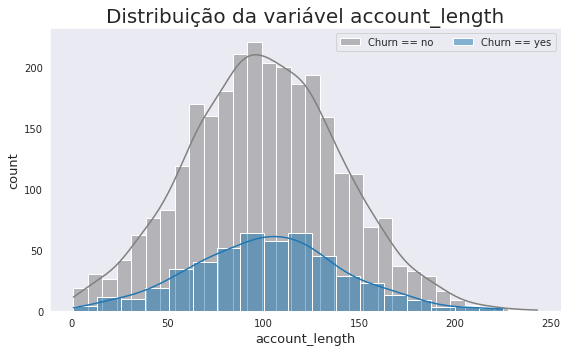

In [ ]:
f, ax = plt.subplots(figsize=(8,5))
plt.title('Distribuição da variável account_length', fontsize = 20)
sns.histplot(data=df_train[df_train['churn'] == 'no'], x = 'account_length', kde=True, label = 'Churn == no', color='gray')
sns.histplot(data=df_train[df_train['churn'] == 'yes'], x = 'account_length', kde=True, label = 'Churn == yes')
ax.legend(ncol = 2, loc = 'best', frameon = True)
plt.xlabel('account_length', fontsize=13)
plt.ylabel('count', fontsize=13)
plt.tight_layout()
plt.show()

A distribuição segue em formato de sino, tanto para 'churn == no' quanto para 'churn == yes', pode=se dizer que essa variável aleatória segue uma distribuição normal.

## Q7. A variável area_code segue a mesma distribuição quando relacionada com a variável churn yes | no? 

In [ ]:
# Valores únicos
df_train['area_code'].unique()

array(['area_code_415', 'area_code_408', 'area_code_510'], dtype=object)

In [ ]:
area_code = df_train['area_code'].value_counts().reset_index().rename(columns={'area_code': 'count'})
area_code['distribuicao'] = area_code['count'] / area_code['count'].sum()
area_codearea_code = df_train['area_code'].value_counts().reset_index().rename(columns={'area_code': 'count'})
area_code['distribuicao'] = area_code['count'] / area_code['count'].sum()
area_codearea_code = df_train['area_code'].value_counts().reset_index().rename(columns={'area_code': 'count'})
area_code['distribuicao'] = area_code['count'] / area_code['count'].sum()
area_code

,index,count,distribuicao
0,area_code_415,1655,0.496550
1,area_code_510,840,0.252025
2,area_code_408,838,0.251425


In [ ]:
area_code_yes = df_train[df_train['churn'] == 'yes']['area_code'].value_counts().reset_index().rename(columns={'area_code': 'count'})
area_code_yes['distribuicao'] = area_code_yes['count'] / area_code_yes['count'].sum()
area_code_yes

,index,count,distribuicao
0,area_code_415,236,0.488613
1,area_code_510,125,0.258799
2,area_code_408,122,0.252588


In [ ]:
area_code_no = df_train[df_train['churn'] == 'no']['area_code'].value_counts().reset_index().rename(columns={'area_code': 'count'})
area_code_no['distribuicao'] = area_code_no['count'] / area_code_no['count'].sum()
area_code_no

,index,count,distribuicao
0,area_code_415,1419,0.497895
1,area_code_408,716,0.251228
2,area_code_510,715,0.250877


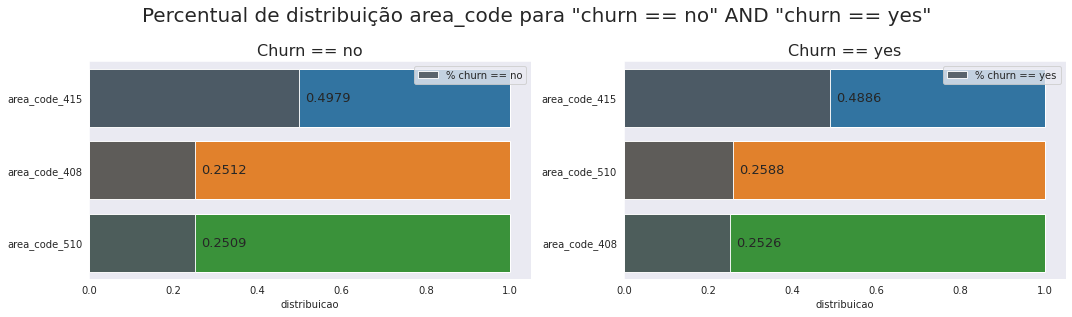

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize=(15, 4))
area_code['percent'] = 1
fig.suptitle('Percentual de distribuição area_code para "churn == no" AND "churn == yes"', fontsize = 20, y = 1.09)
g1 = sns.barplot(y = area_code['index'].unique(), x = area_code['percent'], orient = 'h', ax = ax[0])
g1.set_title('Churn == no', fontsize=16)
g1_1 = sns.barplot(y = area_code_no['index'].unique(), x = area_code_no['distribuicao'], orient='h', color='#4E5861', label = '% churn == no', ax = ax[0], alpha = .9)
g1_1.legend()
g1.legend()
for index, row  in zip(range(len(area_code_no['index'])), area_code_no['distribuicao']):
  g1_1.text(row + 0.0150, index + 0.05, round(row, 4), fontsize = 13)
g2 = sns.barplot(y = area_code['index'].unique(), x = area_code['percent'], orient = 'h', ax = ax[1])
g2.set_title('Churn == yes', fontsize=16)
g2_2 = sns.barplot(y = area_code_yes['index'].unique(), x = area_code_yes['distribuicao'], orient='h', color = '#4E5861', label = '% churn == yes', ax = ax[1], alpha = .9)
g2_2.legend()
for index, row  in zip(range(len(area_code_yes['index'])), area_code_yes['distribuicao']):
  g2_2.text(row + 0.0150, index + 0.05, round(row, 4), fontsize = 13)
plt.tight_layout()
plt.show()

Visualizando os gráficos acima, conclue-se que o percentual de ocorrências para cada faixa da variável area_code, seguem o mesmo percentual quando relacionadas com a variável target.
Exemplo: Quando relacionamos a faixa area_code_415 da variável area_code com a variável target (churn 'no' or 'yes'), o percentual de ocorrências da faixa se mantém.

## Q8. Clientes com "international_plan == 0" dão mais churn?

In [ ]:
df_train['international_plan'].value_counts()

no     3010
yes     323
Name: international_plan, dtype: int64

In [ ]:
int_churn = df_train.loc[(df_train['international_plan'] == 'yes') & (df_train['churn'] == 'yes')]
int_noChurn = df_train.loc[(df_train['international_plan'] == 'no') & (df_train['churn'] == 'yes')]
int_noChurnPercenet = int_noChurn.shape[0] / df_train.loc[(df_train['churn'] == 'yes')].shape[0]
int_churnPercent = int_churn.shape[0] / df_train.loc[(df_train['churn'] == 'yes')].shape[0]

In [ ]:

fig = go.Figure(go.Waterfall(
    name = "20", orientation = "v",
    measure = ["relative", "relative", "total"],
    x = ["international_plan == no", "international_plan == yes", "Total"],
    textposition = "outside",
    text = [round(int_noChurnPercenet, 2), round(int_churnPercent, 2), 1],
    y = [int_noChurnPercenet, int_churnPercent, 1],
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))
fig.update_layout(
        title = {'text': "Percentual de ocorrências das categorias da variável 'international_plan' and 'churn == yes'", 
                 'x': .5,
                 'y': .9,
                 'font': {'size': 19}
                 }
)
fig.show()

Visualindo o gráfico, podemos observar que clientes que não tem o internation_plan, são mais propensos a dar o churn, isso representaça 0.72 da base. Em contra-partida, clientes com o plano, são menos propensos, pois representam 0.28 da base.

## Q9. Clientes sem voice_mail_plan são mais propensos a dar o churn? 

In [ ]:
df_train['voice_mail_plan'].value_counts()

no     2411
yes     922
Name: voice_mail_plan, dtype: int64

In [ ]:
voice_mailChurn = df_train.loc[(df_train['voice_mail_plan'] == 'yes') & (df_train['churn'] == 'yes')]
noVoice_mailChurn = df_train.loc[(df_train['voice_mail_plan'] == 'no') & (df_train['churn'] == 'yes')]
noVoiceMail_ChurnPercenet = noVoice_mailChurn.shape[0] / df_train.loc[(df_train['churn'] == 'yes')].shape[0]
voiceMail_ChurnPercenet = voice_mailChurn.shape[0] / df_train.loc[(df_train['churn'] == 'yes')].shape[0]

In [ ]:

fig = go.Figure(go.Waterfall(
    name = "20", orientation = "v",
    measure = ["relative", "relative", "total"],
    x = ["voice_mail_plan == no", "voice_mail_plan == yes", "Total"],
    textposition = "outside",
    text = [round(noVoiceMail_ChurnPercenet, 2), round(voiceMail_ChurnPercenet, 2), 1],
    y = [noVoiceMail_ChurnPercenet, voiceMail_ChurnPercenet, 1],
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))
fig.update_layout(
        title = {'text': "Percentual de ocorrências das categorias da variável 'voice_mail_plan' and 'churn == yes'", 
                 'x': .5,
                 'y': .9,
                 'font': {'size': 19}
                 }
)


Clientes que não tem o voice_mail_plan são mais propensos a dar o churn, esses clientes representam 0.83 da base quanddo relacionado a variável alvo, enquanto clientes que tem o plano são menos propensos a dar o churn, representam 0.17 da base quando relacionado com a variável alvo.


## É importante destacar que, segundo essa análise e a anterior, clientes que possuem algum tipo de plano são menos propensos a dar o churn. Neste caso, planos podem servir para fidelizar clientes.

## Q10. Qual o resumo estatístico para os atributos numéricos?

In [ ]:
df_train.iloc[:, 6:21].describe()

,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


## Q11. Plotando Matriz de Dispersão para os Atributos Numéricos

In [ ]:
attributes = df_train.columns[7:21]
scatter_matrix(df_train[attributes], figsize=(30, 30))
plt.show()

Output hidden; open in https://colab.research.google.com to view.

As variáveis numéricas tendem a seguir a distribuição normal, com exceção das variáveis "number_customer_service_calls, total_intI_calls". Irei fazer uma análise individual para essas variáveis.
Algumas variáveis tem entre si uma relação de linearidade positiva.

## Q12. Qual o resumo estatístico quando o cliente da churn?

In [ ]:
final = []
for j in df_train['churn'].unique():
  dados = {}; dados['variavel'] = []; dados['media'] = []; dados['mediana'] = []; dados['min'] = []; dados['max'] = []; dados['std'] = [];
  for i in range(13):
    dados['variavel'].append(attributes[i])
    dados['media'].append(df_train.loc[(df_train['churn'] == j)][attributes[i]].mean())
    dados['mediana'].append(df_train.loc[(df_train['churn'] == j)][attributes[i]].median())
    dados['min'].append(df_train.loc[(df_train['churn'] == j)][attributes[i]].min())
    dados['max'].append(df_train.loc[(df_train['churn'] ==  j)][attributes[i]].max())
    dados['std'].append(df_train.loc[(df_train['churn'] ==  j)][attributes[i]].std())
  final.append(dados)
noChurn = pd.DataFrame.from_dict(final[0])
yesChurn = pd.DataFrame.from_dict(final[1])

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(data=[
    go.Bar(name='No Churn', x=noChurn['variavel'], y=noChurn['media'], text = round(noChurn['media'], 2), textposition='auto', ),
    go.Bar(name='Yes Churn', x=noChurn['variavel'], y=yesChurn['media'], text = round(yesChurn['media'], 2), textposition='auto')
])
fig.update_layout(barmode='group',
                  title = {'text': "Qual a diferenças das médias das variáveis, quando relacionadas a churn e não churn", 
                 'x': .5,
                 'y': .9,
                 'font': {'size': 19}
                 }
                 )
fig.show()

# 4 - Preparação dos dados 


In [ ]:
df_train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,0.32,0.524793,0.5,0.0,1.0,0.490196,0.755701,0.666667,0.755701,0.542755,0.582353,0.542866,0.595750,0.408451,0.595935,0.500,0.15,0.500000,0.111111,0.0
1,0.70,0.438017,0.5,0.0,1.0,0.509804,0.460661,0.745455,0.460597,0.537531,0.605882,0.537690,0.621840,0.492958,0.622236,0.685,0.15,0.685185,0.111111,0.0
2,0.62,0.561983,0.5,0.0,0.0,0.000000,0.693843,0.690909,0.693830,0.333242,0.647059,0.333225,0.374933,0.500000,0.375374,0.610,0.25,0.609259,0.000000,0.0
3,0.70,0.342975,0.0,1.0,0.0,0.000000,0.853478,0.430303,0.853454,0.170195,0.517647,0.170171,0.467187,0.394366,0.467424,0.330,0.35,0.329630,0.222222,0.0
4,0.72,0.305785,0.5,1.0,0.0,0.000000,0.475200,0.684848,0.475184,0.407754,0.717647,0.407959,0.440290,0.619718,0.440526,0.505,0.15,0.505556,0.333333,0.0


## 4.1 - Limpeza da base

In [ ]:
# Dropando coluna unnamed: 0
df_train.drop('Unnamed: 0', axis = 1, inplace = True)

## 4.2 - Categorização das variáveis categóricas independentes

In [ ]:
# Listando atributos categóricos
categoric_features = ['state', 'area_code', 'international_plan', 'voice_mail_plan']

In [ ]:
# OrdinalEncoder, é usado para codificar atributos categóricos como um integer array
oe = OrdinalEncoder()
for column in categoric_features:
  oe.fit(np.array(df_train[column]).reshape(-1, 1))
  np.save('/gdrive/My Drive/Colab Notebooks/Churn_Telecom/models/' + str(column) + '_OrdinalEncoder.npy', oe.categories_)
  df_train[column] = oe.transform(np.array(df_train[column]).reshape(-1, 1))

## 4.3 - Categorização da variável alvo 

In [ ]:
# Carregando LabelEncoder, usado para codificar a variável alvo
lb = LabelEncoder()

In [ ]:
# Normalizando a variável alvo e salvando o modelo
lb.fit(df_train['churn'])
df_train['churn'] = lb.transform(df_train['churn'])
np.save('/gdrive/My Drive/Colab Notebooks/Churn_Telecom/models/Churn_LabelEncoder.npy', lb.classes_)

## 4.4 - Normalização dos atributos numéricos

In [ ]:
# Carregando o MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
# Ajustando valores normalizados nas colunas e salvando os modelos
attributes = df_train.columns
for column in attributes:
  scaler.fit(np.array(df_train[column]).reshape(-1, 1))
  df_train[column] = scaler.transform(np.array(df_train[column]).reshape(-1, 1))
  joblib.dump(scaler, '/gdrive/My Drive/Colab Notebooks/Churn_Telecom/models/'+ str(column) +'MinMaxScaller.mod')

## 4.5 - Correlação das variáveis

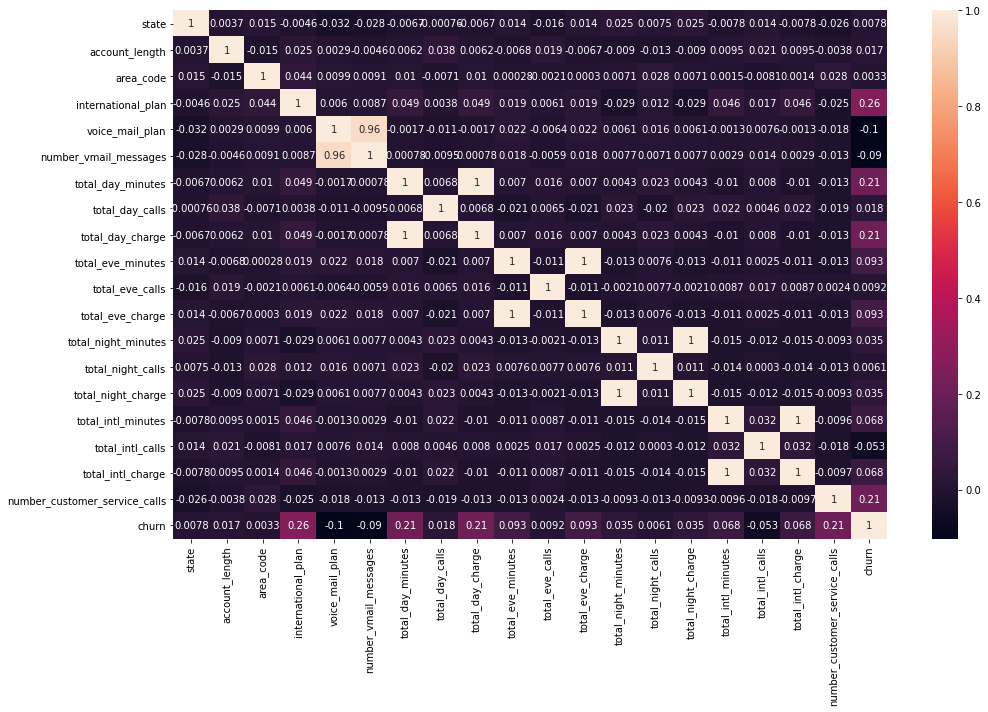

In [ ]:
# Plotando o gráfico da correlação
plt.figure(figsize=(15, 10))
sns.heatmap(df_train.corr(), annot=True)
plt.tight_layout()
plt.show()

In [ ]:
# Separando a base em treino e teste
X_train, X_test, y_train, y_test = train_test_split(df_train.iloc[:, :19], 
                                                    df_train.iloc[:, 19],
                                                    test_size = .7)

## 4.6 - Balanceando os dados com SMOTE

In [ ]:
# Carregando a função SMOTE
sm = SMOTE(random_state=42)

In [ ]:
# Inputando novos valores 
X_res, y_res = sm.fit_resample(df_train.iloc[:, :19], df_train.iloc[:, 19])

In [ ]:
# Valores únicos e suas respectivas contagens.
unique, counts = np.unique(y_res, return_counts=True)
dict(zip(unique, counts))

{0.0: 2850, 1.0: 2850}

Agora, há 2850 registros para a classe 0 e 2850 registros para a classe 1. Os dados estão balanceados.

# 5 - Carregandos os algoritmos

In [ ]:
# Carregando algoritmos
lgbm = LGBMClassifier(); tree = DecisionTreeClassifier(); randomForest = RandomForestClassifier()
svc = SVC(); lr = LogisticRegression(); xgb = XGBClassifier(); gb = GaussianNB();

In [ ]:
model_list = [lgbm, tree, randomForest, lr, xgb, gb]
model_name_list = ['LGBM', 'DecisionTree', 'RandomForest' ,'LogisticRegression', 'XGBOOST', 'GaussianNB']

# 6 - Carregando base de teste

In [ ]:
df_test = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Churn_Telecom/projeto4_telecom_teste.csv')
# Excluindo coluna não útil
df_test.drop('Unnamed: 0', axis = 1, inplace = True)
#  Categorizando como int
categoric_features = ['state', 'area_code', 'international_plan', 'voice_mail_plan']
oe = OrdinalEncoder()
for column in categoric_features:
  oe.categories_ = np.load('/gdrive/My Drive/Colab Notebooks/Churn_Telecom/models/'+ str(column) + '_OrdinalEncoder.npy', allow_pickle=True)
  df_test[column] = oe.transform(np.array(df_test[column]).reshape(-1, 1))
# Carregando LabelEncoder, usado para codificar a variável alvo
lb = LabelEncoder()
lb.classes_ = np.load('/gdrive/My Drive/Colab Notebooks/Churn_Telecom/models/Churn_LabelEncoder.npy', allow_pickle=True)
df_test['churn'] = lb.transform(np.array(df_test['churn']).reshape(-1, 1))
# Normalizando os dados
scaler = MinMaxScaler()
attributes = df_test.columns
for column in attributes:
  scaler = joblib.load('/gdrive/My Drive/Colab Notebooks/Churn_Telecom/models/'+ str(column) +'MinMaxScaller.mod')
  df_test[column] = scaler.transform(np.array(df_test[column]).reshape(-1, 1))

In [ ]:
df_test.shape

(1667, 20)

# 7 - Treinando os algoritmos

In [ ]:
dic_models = {}; dic_models['Model'] = []; dic_models['Accuracy'] = []; dic_models['Precision'] = [];
dic_models['Recall'] = []; dic_models['F1_Score'] = []; dic_models['ROC_AUC'] = []; 
dic_predicts = {}; dic_predicts['Model'] = []; dic_predicts['Predicts'] = []; dic_predicts['Predicts_Prob'] = [];

In [ ]:
for name, model in zip(model_name_list, model_list):
  print(model.fit(X_res, y_res))
  filename = '/gdrive/My Drive/Colab Notebooks/Churn_Telecom/models/finalized_model' + str(name) + '.joblib'
  pickle.dump(model, open(filename, 'wb'))
  predicts = model.predict(np.array(df_test.iloc[:, :19]))
  predicts_prob = model.predict_proba(np.array(df_test.iloc[:, :19]))
  dic_models['Model'].append(name)
  dic_models['Accuracy'].append(accuracy_score(df_test.iloc[:, 19], predicts))
  dic_models['Precision'].append(precision_score(df_test.iloc[:, 19], predicts))
  dic_models['Recall'].append(recall_score(df_test.iloc[:, 19], predicts))
  dic_models['F1_Score'].append(f1_score(df_test.iloc[:, 19], predicts))
  dic_models['ROC_AUC'].append(roc_auc_score(df_test.iloc[:, 19], predicts))
  dic_predicts['Model'].append(name)
  dic_predicts['Predicts'].append(predicts)
  dic_predicts['Predicts_Prob'].append(predicts_prob)
modelos = pd.DataFrame.from_dict(dic_models)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', 

# 8 - Selecionando o melhor algoritmo

In [ ]:
modelos.sort_values(by='Recall', ascending=False).reset_index().drop('index', axis = 1)

,Model,Accuracy,Precision,Recall,F1_Score,ROC_AUC
0,LogisticRegression,0.776845,0.354331,0.803571,0.491803,0.788134
1,RandomForest,0.953809,0.865672,0.776786,0.818824,0.879037
2,LGBM,0.961608,0.930108,0.772321,0.843902,0.881656
3,XGBOOST,0.929214,0.722689,0.767857,0.744589,0.861060
4,GaussianNB,0.790642,0.363834,0.745536,0.489019,0.771590
5,DecisionTree,0.887822,0.562712,0.741071,0.639692,0.825837


Para este projeto, o melhor algoritmo seria que o tivesse um Recall alto mesmo que ele tenha uma Precision baixa. Os analistas receberão alguns alertas falsos, mas quase todos os clientes podem ser retidos através campanhas/promoções. E o modelo que satisfez esse objetivo é o Modelo de Regressão Logística/Logistic Regression, com um recall de 0.803571.

# 9 - Visualizando previsões finais na base de dados

In [ ]:
no_churn = []
yes_churn = []
for i in dic_predicts['Predicts_Prob'][3]:
  no_churn.append(i[0])
  yes_churn.append(i[1])
df_test['Predicts'] = dic_predicts['Predicts'][3]
df_test['PredictsProb_noChurn'] = no_churn
df_test['PredictsProb_Churn'] = yes_churn

In [ ]:
df_test.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,Predicts,PredictsProb_noChurn,PredictsProb_Churn
0,0.22,0.413223,1.0,0.0,0.0,0.000000,0.202109,0.745455,0.202046,0.582623,0.429412,0.582659,0.572351,0.281690,0.572624,0.530,0.15,0.529630,0.333333,0.0,0.0,0.722918,0.277082
1,0.52,0.561983,1.0,0.0,0.0,0.000000,0.637400,0.521212,0.637324,0.673082,0.817647,0.673245,0.190963,0.338028,0.191273,0.475,0.35,0.475926,0.000000,0.0,0.0,0.802184,0.197816
2,0.70,0.421488,0.0,0.0,1.0,0.568627,0.840080,0.575758,0.840040,0.652461,0.617647,0.652540,0.745293,0.661972,0.745368,0.685,0.30,0.685185,0.111111,0.0,1.0,0.328871,0.671129
3,0.64,0.404959,0.5,0.0,0.0,0.000000,0.618016,0.745455,0.618042,0.347539,0.517647,0.347460,0.530931,0.345070,0.531381,0.785,0.10,0.785185,0.111111,0.0,0.0,0.532416,0.467584
4,0.80,0.442149,0.5,0.0,0.0,0.000000,0.562714,0.472727,0.562710,0.340940,0.594118,0.340990,0.487628,0.521127,0.487747,0.385,0.20,0.385185,0.222222,0.0,0.0,0.712782,0.287218


# FIM